# <a id='toc1_'></a>[**Final Project: Classify Waste Products Using Transfer Learning**](#toc0_)


In [1]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.26.0 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1

### <a id='toc1_3_2_'></a>[Importing Required Libraries](#toc0_)


In [2]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


## <a id='toc1_4_'></a>[**Task 1: Print the version of tensorflow**](#toc0_)

Upload the screenshot of the version of tensorflow named tensorflow_version.png.

Hint: Use `tf.__version__` to print the version of tensorflow.


In [3]:
# Task 1
print(tf.__version__)

2.17.0


## <a id='toc1_5_'></a>[Background](#toc0_)


**Transfer learning** uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. You can leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:

1.  Initialize base model, and load pre-trained weights (e.g. ImageNet)
2.  "Freeze" layers in the base model by setting `training = False`
3.  Define a new model that goes on top of the output of the base model's layers.
4.  Train resulting model on your data set.

## <a id='toc1_6_'></a>[Create a model for distinguishing recyclable and organic waste images](#toc0_)

### <a id='toc1_6_1_'></a>[Dataset](#toc0_)

You will be using the [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).

Your goal is to train an algorithm on these images and to predict the labels for images in your test set (1 = recyclable, 0 = organic).

### <a id='toc1_6_2_'></a>[Importing Data](#toc0_)

This will create a `o-vs-r-split` directory in your environment.


In [4]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [01:02<00:00, 19.24file/s]

Finished extracting file
Finished extracting file


### <a id='toc1_6_3_'></a>[Define configuration options](#toc0_)

It's time to define some model configuration options.

*   **batch size** is set to 32.
*   The **number of classes** is 2.
*   You will use 20% of the data for **validation** purposes.
*   You have two **labels** in your dataset: organic (O), recyclable (R).


In [5]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### <a id='toc1_6_4_'></a>[Loading Images using ImageGeneratorClass](#toc0_)

Transfer learning works best when models are trained on smaller datasets. 

The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


#### <a id='toc1_6_4_1_'></a>[ImageDataGenerators](#toc0_)


Now you will create ImageDataGenerators used for training, validation and testing.

Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process. 



In [6]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [8]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


## <a id='toc1_7_'></a>[**Task 2: Create a `test_generator` using the `test_datagen` object**](#toc0_)

Upload the screenshot of the code and the output of the test generator as test_generator.png.

Please use the following parameters:

*   **directory** should be set to `path_test`.
*   **class_mode** should be set to `'binary'`.
*   **seed** should be set to `seed`.
*   **batch_size** should be set to `batch_size`.
*   **shuffle** should be set to `False`.
*   **target_size** should be set to `(img_rows, img_cols)`.

Hint: the format should be like:

```python
test_generator = test_datagen.flow_from_directory(
    directory=,
    class_mode=,
    seed=,
    batch_size=,
    shuffle=,
    target_size=
)
```


In [9]:
# Task 2: Create a `test_generator` using the `test_datagen` object
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 200 images belonging to 2 classes.


## <a id='toc1_8_'></a>[**Task 3: Print the length of the `train_generator`**](#toc0_)

Upload the screenshot of the code and the output of the length of the train generator as train_generator len.png.

Hint: Use `len(train_generator)` to print the length of the `train_generator`.


In [10]:
# Task 3: print the length of the `train_generator`
print(len(train_generator))

25


Let's look at a few augmented images:


Labels: ['O', 'O', 'O', 'O', 'O']


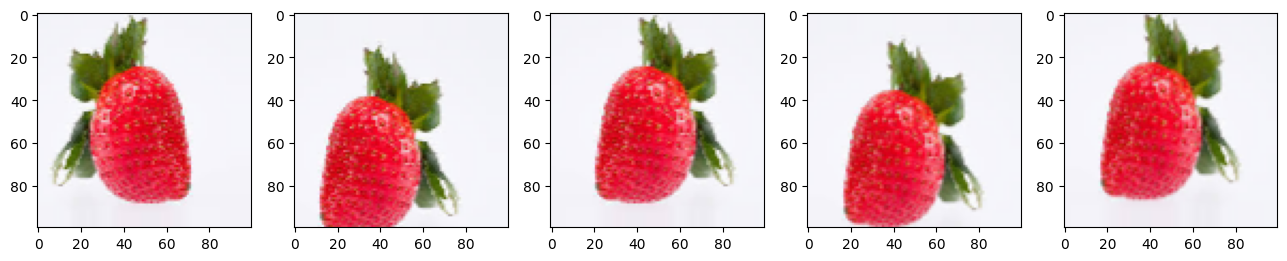

In [11]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### <a id='toc1_8_1_'></a>[Pre-trained Models](#toc0_)

Pre-trained models are saved networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.

#### <a id='toc1_8_1_1_'></a>[VGG-16](#toc0_)

Let us load the VGG16 model.


In [12]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


We flatten the output of a vgg model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [13]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, you freeze the basemodel.


In [14]:
for layer in basemodel.layers: 
    layer.trainable = False

Create a new model on top. You add a Dropout layer for regularization, only these layers will change as for the lower layers you set `training=False` when calling the base model.


In [15]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## <a id='toc1_9_'></a>[**Task 4: Print the summary of the model**](#toc0_)

Upload the screenshot of the code and output of the summary of the model model_summary.png.

Hint: Use `model.summary()` to print the summary of the model.


In [16]:
# Task: print the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## <a id='toc1_10_'></a>[**Task 5: Compile the model**](#toc0_)

Upload the screenshot of the code as model_compile.png.

You will compile the model using the following parameters:

*   **loss**: `'binary_crossentropy'`.
*   **optimizer**: `optimizers.RMSprop(learning_rate=1e-4)`.
*   **metrics**: `['accuracy']`.

Hint: Use `model.compile()` to compile the model:
    
```python
model.compile(
    loss=,
    optimizer=,
    metrics=
)
```


In [17]:
for layer in basemodel.layers: 
    layer.trainable = False

# Task 5: Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

You will use early stopping to avoid over-training the model.


In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## <a id='toc1_11_'></a>[Fit and train the model](#toc0_)


In [19]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5708 - loss: 0.7183  
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 16s/step - accuracy: 0.6250 - loss: 0.6860 - val_accuracy: 0.7552 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6714 - loss: 0.5872 
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 15s/step - accuracy: 0.7188 - loss: 0.5396 - val_accuracy: 0.7865 - val_loss: 0.4890 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7181 - loss: 0.5291 
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 15s/step - accuracy: 0.7312 - loss: 0.5295 - val_accuracy: 0.7708 - val_loss: 0.4577 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7254 - loss: 0.4772 
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.7625 - loss: 0.4569 - val_accuracy: 0.8229 - val_loss: 0.4034 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s

### <a id='toc1_11_1_'></a>[Plot loss curves for training and validation sets (extract_feat_model)](#toc0_)


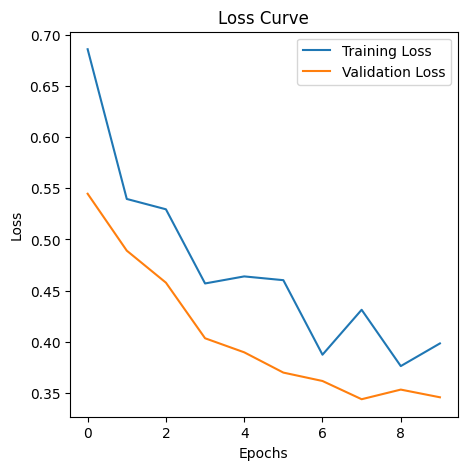

In [20]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### <a id='toc1_11_2_'></a>[**Task 6: Plot accuracy curves for training and validation sets (extract_feat_model)**](#toc0_)

Upload the screenshot of the code and the output of the plot accuracy curve as plot_accuracy_curve.png.

Hint: Similar to the loss curves. Use `plt.plot()` to plot the accuracy curves for training and validation sets.

- `figsize=(5, 5)`
- `plt.plot(history.history['accuracy'], label='Training Accuracy')`
- `plt.plot(history.history['val_accuracy'], label='Validation Accuracy')`
- **Title**: `'Accuracy Curve'`
- **xlabel**: `'Epochs'`
- **ylabel**: `'Accuracy'`

**NOTE**: As training is a stochastic process, the loss and accuracy graphs may differ across runs. As long as the general trend shows decreasing loss and increasing accuracy, the model is performing as expected and full marks will be awarded for the task.


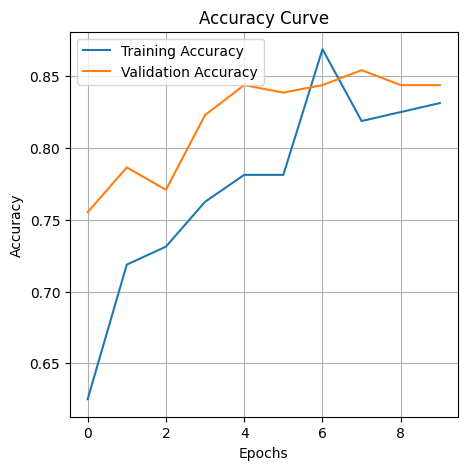

In [21]:
import matplotlib.pyplot as plt

history = extract_feat_model
## Task 6: Plot accuracy curves for training and validation sets
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_12_'></a>[Fine-Tuning model](#toc0_)

Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model. 

You will **unfreeze** one layer from the base model and train the model again.


In [22]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


Similar to what you did before, you will create a new model on top, and add a Dropout layer for regularization.


In [23]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
lr: 9.048374180359596e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5019 - loss: 0.7410  
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 16s/step - accuracy: 0.5562 - loss: 0.6997 - val_accuracy: 0.7083 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 2/10
lr: 8.187307530779819e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7324 - loss: 0.5687 
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 19s/step - accuracy: 0.7375 - loss: 0.5356 - val_accuracy: 0.7500 - val_loss: 0.4925 - learning_rate: 9.0484e-05
Epoch 3/10
lr: 7.408182206817179e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7456 - loss: 0.4925 
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 15s/step - accuracy: 0.7437 - loss: 0.5038 - val_accuracy: 0.8281 - val_loss: 0.4152 - learning_rate: 8.1873e-05
Epoch 4/10
lr: 6.703200460356393e-05━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7276 - loss: 0.5532 
5/5 ━━━━━━━━━━━━━━━━━━━━ 62s 14s/step - accuracy: 0.7812 - loss: 0.4919 - val_accuracy: 0.7969 - val_loss: 0.4298 - learning_rate: 7.4082e-05
Epoch 5/10
lr: 6.065306597126335e-05━━━━━━━━━━━━ 0s

### <a id='toc1_12_1_'></a>[**Task 7: Plot loss curves for training and validation sets (fine tune model)**](#toc0_)

Upload the screenshot of the code and the output of the plot loss curves as plot_loss_curve.png.

Hint: Use `plt.plot()` to plot the loss curves for training and validation sets.
 - `history = fine_tune_model`
- `figsize=(5, 5)`
- `plt.plot(history.history['loss'], label='Training Loss')`
- `plt.plot(history.history['val_loss'], label='Validation Loss')`
- **Title**: `'Loss Curve'`
- **xlabel**: `'Epochs'`
- **ylabel**: `'Loss'`

**NOTE**: As training is a stochastic process, the loss and accuracy graphs may differ across runs. As long as the general trend shows decreasing loss and increasing accuracy, the model is performing as expected and full marks will be awarded for the task.


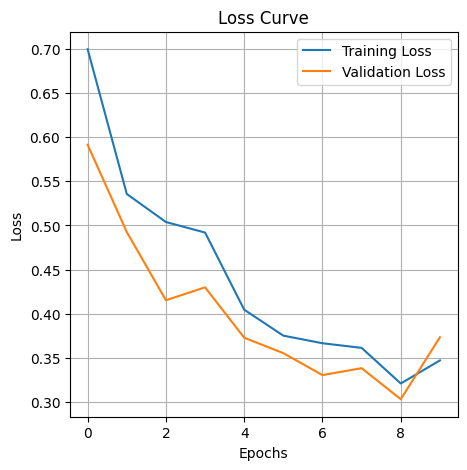

In [24]:
history = fine_tune_model

## Task 7: Plot loss curves for training and validation sets (fine tune model)
history = fine_tune_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_12_2_'></a>[**Task 8: Plot accuracy curves for training and validation sets  (fine tune model)**](#toc0_)

Upload the screenshot of the code and the plot accuracy curve for the fine-tune model as plot_finetune_model.png.

Hint: Similar to the loss curves. Use `plt.plot()` to plot the accuracy curves for training and validation sets.
- `history = fine_tune_model`
- `figsize=(5, 5)`
- `plt.plot(history.history['accuracy'], label='Training Accuracy')`
- `plt.plot(history.history['val_accuracy'], label='Validation Accuracy')`
- **Title**: `'Accuracy Curve'`
- **xlabel**: `'Epochs'`
- **ylabel**: `'Accuracy'`

**NOTE**: As training is a stochastic process, the loss and accuracy graphs may differ across runs. As long as the general trend shows decreasing loss and increasing accuracy, the model is performing as expected and full marks will be awarded for the task.


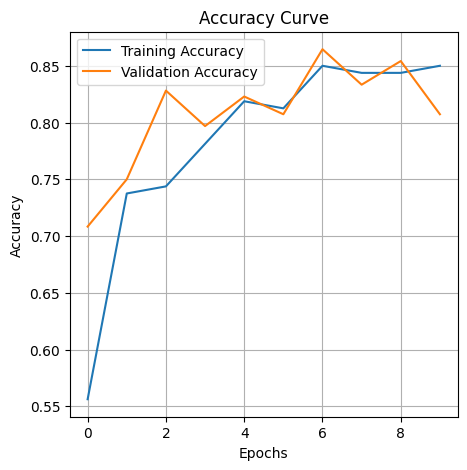

In [25]:
history = fine_tune_model

# Task 8: Plot accuracy curves for training and validation sets  (fine tune model)
history = fine_tune_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_13_'></a>[Evaluate both models on test data](#toc0_)

- Load saved models
- Load test images
- Make predictions for both models
- Convert predictions to class labels
- Print classification report for both models


In [26]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.78      0.80      0.79        50
           R       0.80      0.78      0.79        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.77      0.92      0.84        50
           R       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



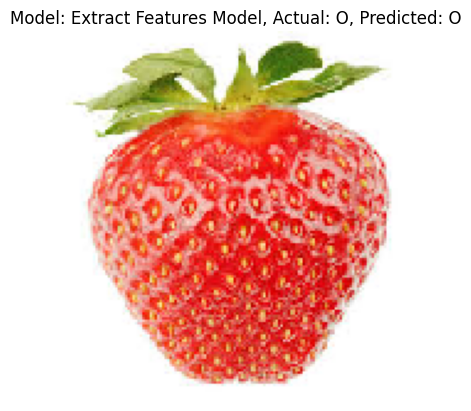

In [27]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

### <a id='toc1_13_1_'></a>[**Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)**](#toc0_)

Upload the screenshot of the code and the extract features model as extract_features_model.png.

Instructions:

- Use `plot_image_with_title` function.
- `index_to_plot = 1`
- `model_name='Extract Features Model'`
- `predicted_label=predictions_extract_feat_model[index_to_plot]`

Hint: Follow the same format as previous plots.

**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘O’, the prediction could be either ‘O’ or ‘R’, both of which are possible outcomes, and full marks will be awarded for the task. 


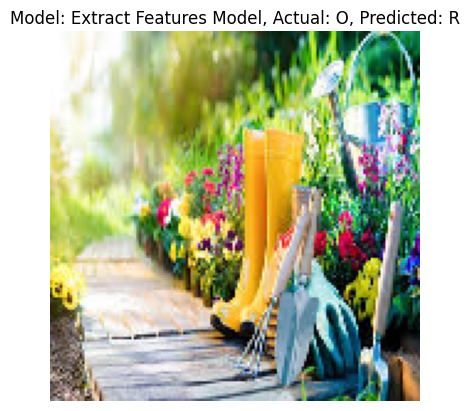

In [28]:
# Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

### <a id='toc1_13_2_'></a>[**Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)**](#toc0_)

Upload the screenshot of the code and the fine-tuned model as finetuned_model.png.

Instructions:

- Use `plot_image_with_title` function.
- `index_to_plot = 1`
- `model_name='Fine-Tuned Model'`
- `predicted_label=predictions_fine_tune_model[index_to_plot]`

Hint: follow the same format as previous plots.

**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘O’, the prediction could be either ‘O’ or ‘R’, both of which are possible outcomes, and full marks will be awarded for the task. 


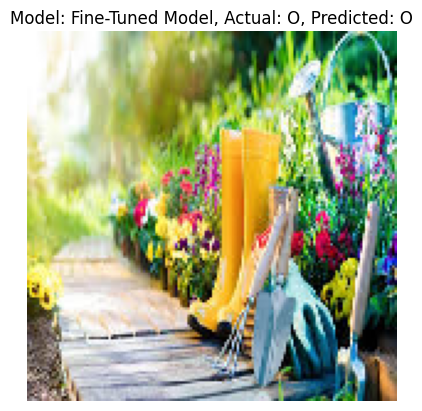

In [29]:
# Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
)

## <a id='toc1_14_'></a>[Author](#toc0_)

Copyright © IBM Corporation. All rights reserved.
